# 4 Hierarchical Clustering Analysis

This notebook performs hierarchical clustering analysis on public utility data and spider abundance data.

Hierarchical clustering is a technique for identifying groups or clusters in multivariate datasets. We do not need to pre-specify the number of clusters beforehand in order to peform the analysis, unlike say, k-means clustering (not part of the unit). A great feature of hierarchical clustering is that the sequence of groupings of observation or features is represented in a tree-based diagram, called dendrogram.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, cophenet
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import ConvexHull
from scipy.stats import spearmanr
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

### 4.1 Load and Prepare Data

We begin with the public utility data of 22 U.S. power companies, which are given in the Public Utility.csv file. The relevant features are as follows:
1.	Fixed charge coverage ratio (income/debt)
2.	Rate of return on capital
3.	Cost per KW capacity in place
4.	Annual load factor
5.	Peak KWH demand growth
6.	Sales (KWH use per year)
7.	Percent nuclear
8.	Total fuel cost (cents per KWH)
Given that the features are defined in different units, we should standardise the data before we create the distance matrix for hierarchical clustering.


In [2]:
# Load the public utility data
url = "https://raw.githubusercontent.com/asim-cv/MAT6206/refs/heads/main/Datasets/PublicUtility.csv"
dat = pd.read_csv(url)

#dat = pd.read_csv("Public Utility.csv")

# Set company names as index and remove the Company column
dat.set_index(dat.iloc[:, -1], inplace=True)
dat = dat.iloc[:, :-1]

print("Data shape:", dat.shape)
print("\nFirst few rows:")
display(dat.head())


# Remove missing values and standardize
dat = dat.dropna()
scaler = StandardScaler()
dat_z = pd.DataFrame(scaler.fit_transform(dat), 
                     index=dat.index, 
                     columns=dat.columns)

print("\nStandardized data shape:", dat_z.shape)
dat_z.head()

Data shape: (22, 8)

First few rows:


,FCCR,Return.on.capital,Cost.per.KW,Annual.load.factor,Peak.KWH.growth,Sales,Perc.nuclear,Tot.fuel.costs
Company,,,,,,,,
Arizona,1.06,9.2,151,54.4,1.6,9077,0.0,0.628
Boston,0.89,10.3,202,57.9,2.2,5088,25.3,1.555
Central,1.43,15.4,113,53.0,3.4,9212,0.0,1.058
Common,1.02,11.2,168,56.0,0.3,6423,34.3,0.700
Consolid,1.49,8.8,192,51.2,1.0,3300,15.6,2.044



Standardized data shape: (22, 8)


,FCCR,Return.on.capital,Cost.per.KW,Annual.load.factor,Peak.KWH.growth,Sales,Perc.nuclear,Tot.fuel.costs
Company,,,,,,,,
Arizona,-0.300057,-0.700750,-0.426938,-0.591310,-0.538611,0.046983,-0.731447,-0.873765
Boston,-1.243092,-0.199030,0.840322,0.211704,-0.341667,-1.103127,0.810687,0.832436
Central,1.752432,2.127130,-1.371171,-0.912516,0.052220,0.085906,-0.731447,-0.082323
Common,-0.521947,0.211469,-0.004518,-0.224218,-0.965322,-0.718219,1.359271,-0.741244
Consolid,2.085268,-0.883194,0.591840,-1.325495,-0.735555,-1.618644,0.219434,1.732470


### 4.2 Distance Matrix and Heatmap

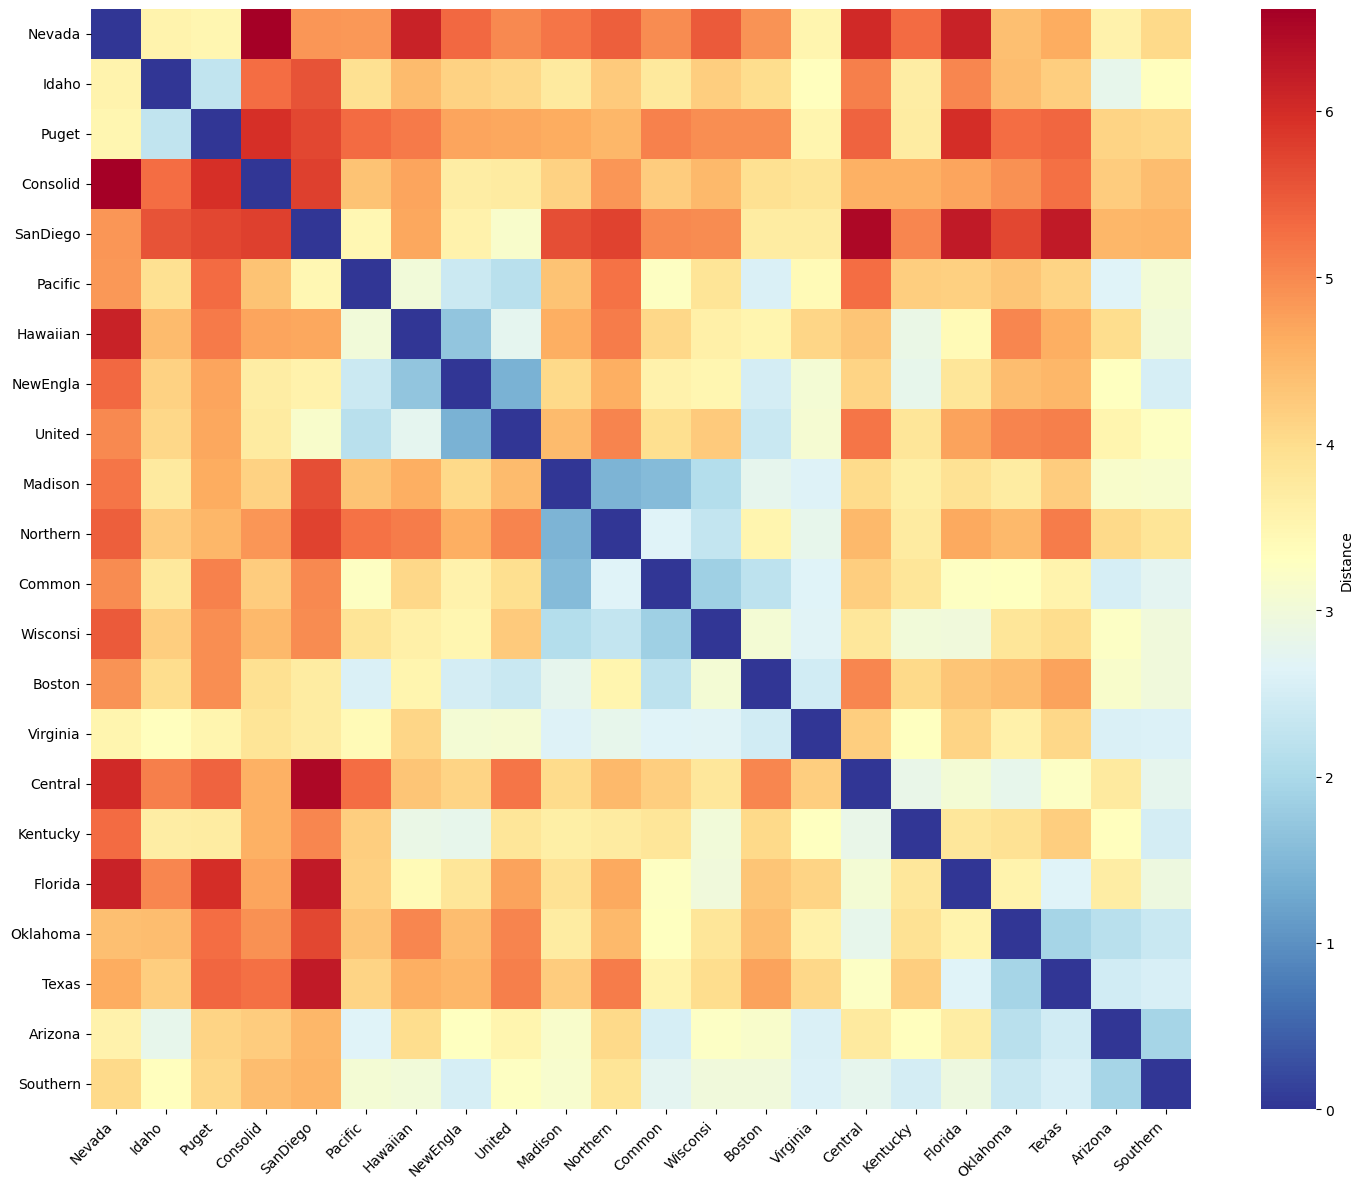

In [3]:
# Distance matrix heatmap with clustering
dist_pu = pdist(dat_z, metric='euclidean')
linkage_matrix = linkage(dist_pu, method='average')
optimal_order = dendrogram(linkage_matrix, no_plot=True)['leaves']

# Reorder and create heatmap
reordered_companies = [dat_z.index[i] for i in optimal_order]
dist_matrix = squareform(dist_pu)[np.ix_(optimal_order, optimal_order)]

plt.figure(figsize=(15, 12))
sns.heatmap(dist_matrix, 
            cmap='RdYlBu_r',
            xticklabels=reordered_companies,
            yticklabels=reordered_companies,
            square=True,
            cbar_kws={'label': 'Distance'})
plt.xticks(rotation=45, ha='right')
plt.tight_layout()



### 4.3 Agglomerative Hierarchical Clustering (AGNES)

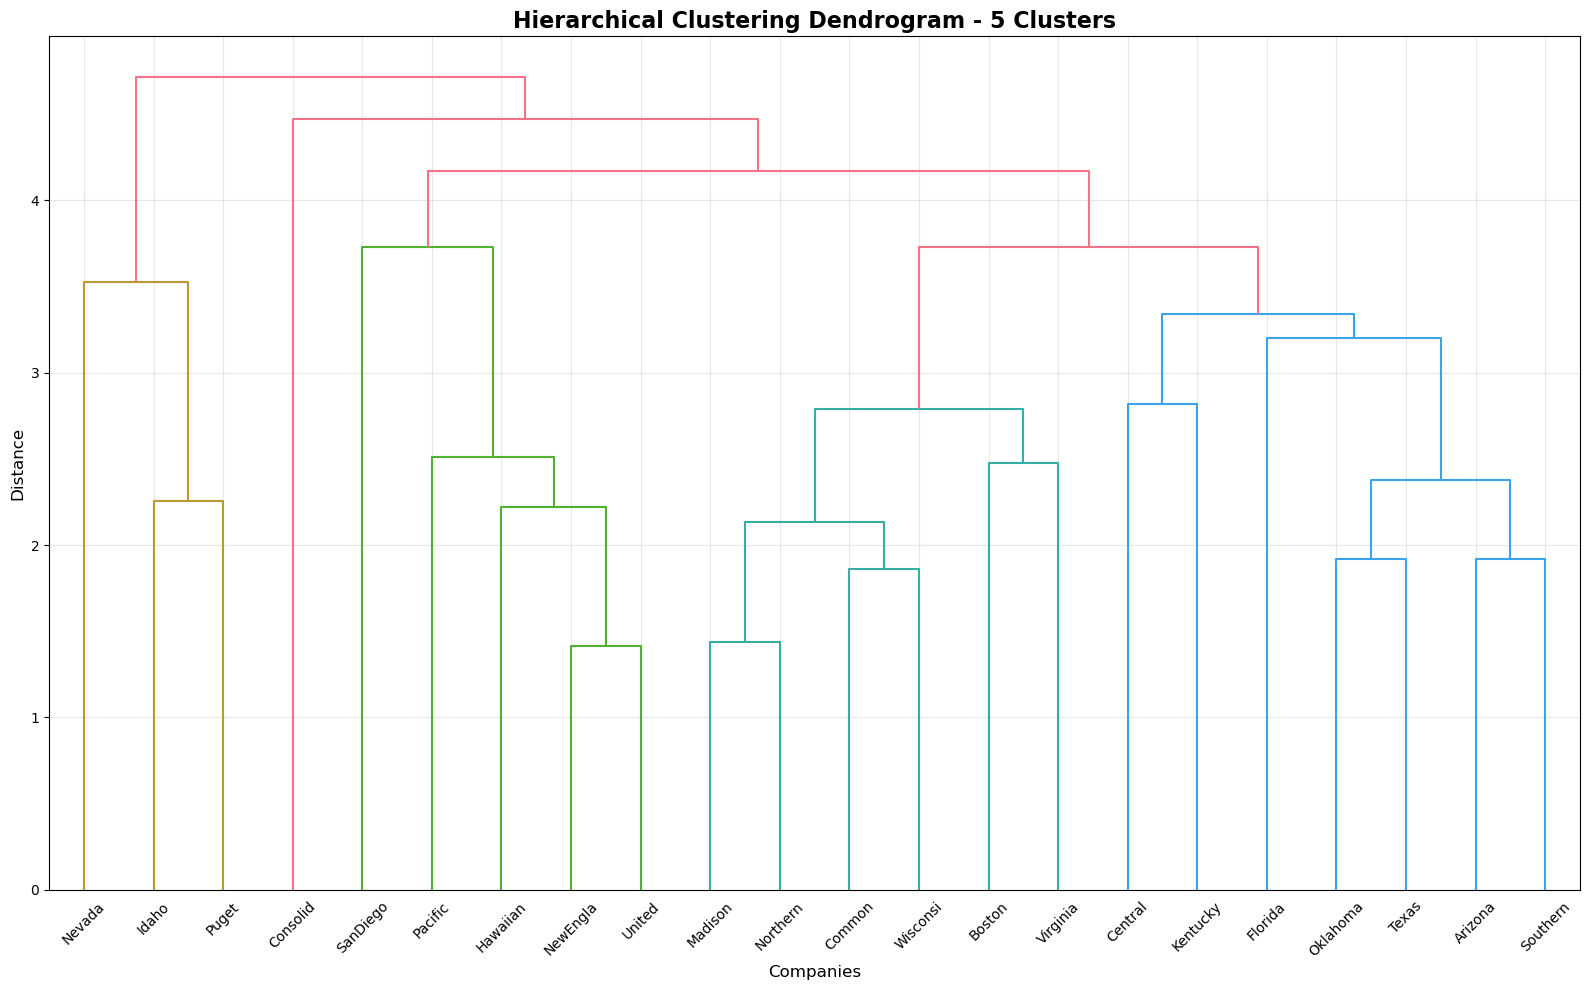

In [4]:
plt.figure(figsize=(16, 10))
dendrogram(linkage_matrix,
           labels=dat_z.index,
           leaf_rotation=45,
           leaf_font_size=10,
           color_threshold=linkage_matrix[-4, 2]) # Set threshold to get 5 clusters

plt.title('Hierarchical Clustering Dendrogram - 5 Clusters', fontsize=16, fontweight='bold')
plt.xlabel('Companies', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

### 4.4 DIANA Style Divisive Hierarchical Clustering Dendrogram

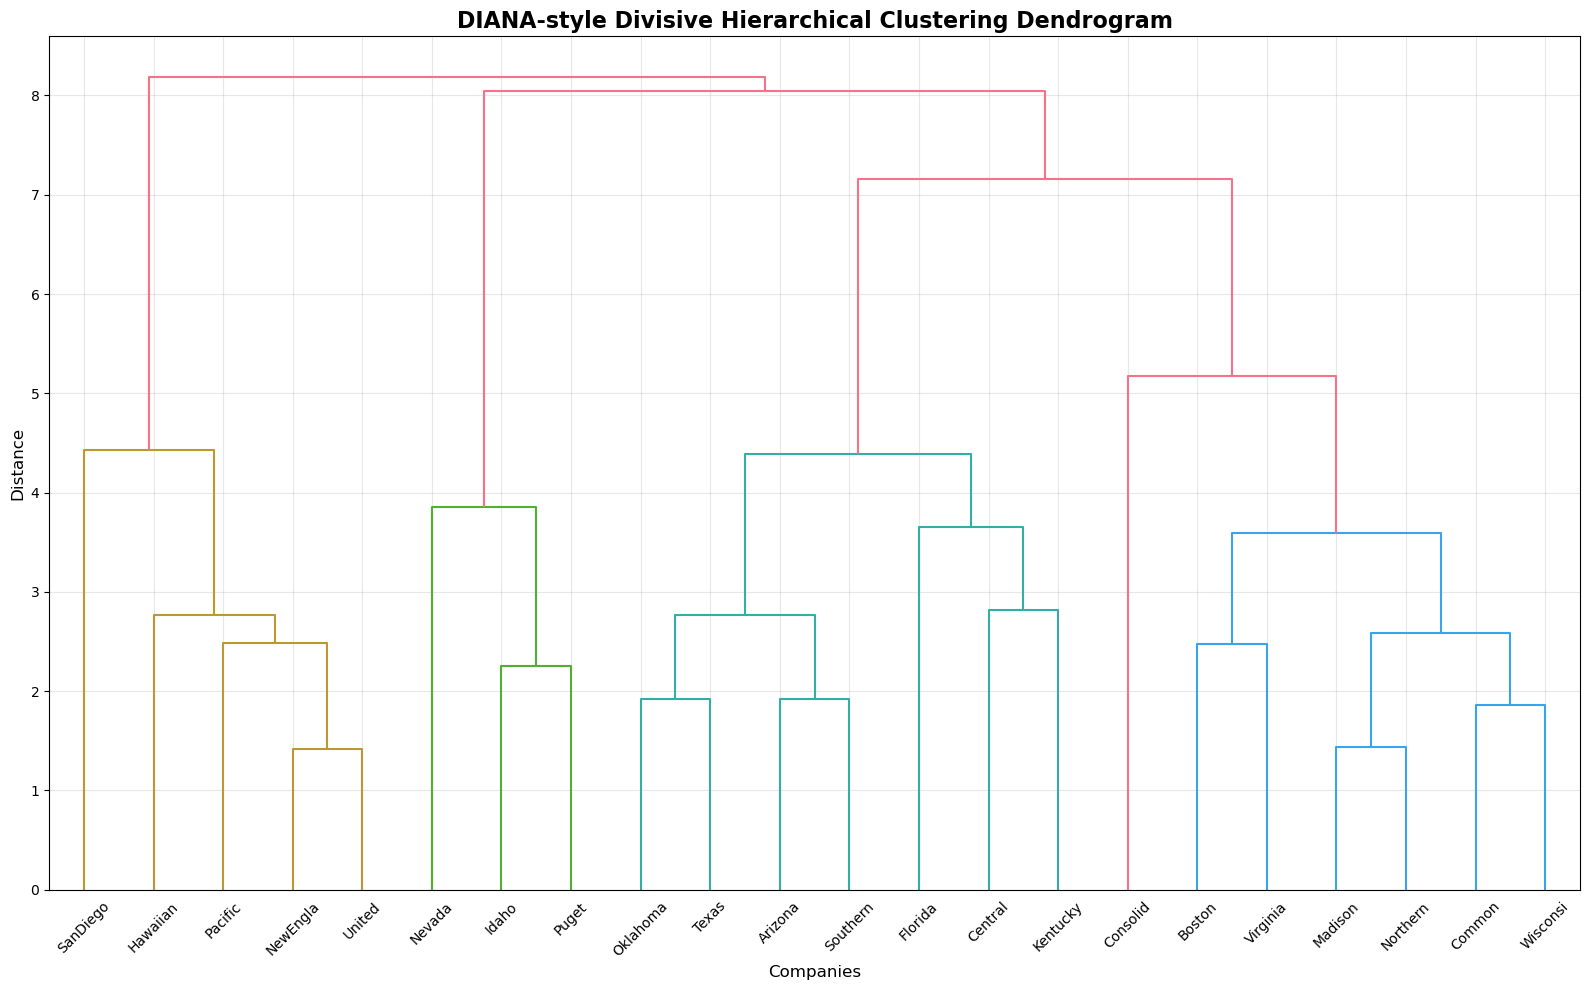

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Since there's no direct DIANA in scipy, we'll use divisive interpretation
# of agglomerative results
linkage_matrix_DIANA = linkage(dat_z, method='ward', metric='euclidean')

# Plot dendrogram from divisive perspective (reading top-down)
plt.figure(figsize=(16, 10))
dendrogram(linkage_matrix_DIANA,
           labels=dat_z.index,
           leaf_rotation=45,
           leaf_font_size=10,
           orientation='top',
           color_threshold=linkage_matrix_DIANA[-4, 2])  # For 5 clusters

plt.title('DIANA-style Divisive Hierarchical Clustering Dendrogram', 
          fontsize=16, fontweight='bold')
plt.xlabel('Companies', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 4.5 Comparison of DIANA vs AGNES

Divisive Hierarchical Clustering Results:
Comparing different linkage methods:
Complete linkage cophenetic correlation: 0.6364
Ward linkage cophenetic correlation: 0.6265
Average linkage cophenetic correlation: 0.7044

Cluster comparison:
Complete linkage creates 5 clusters
Ward linkage creates 5 clusters
Average linkage creates 5 clusters


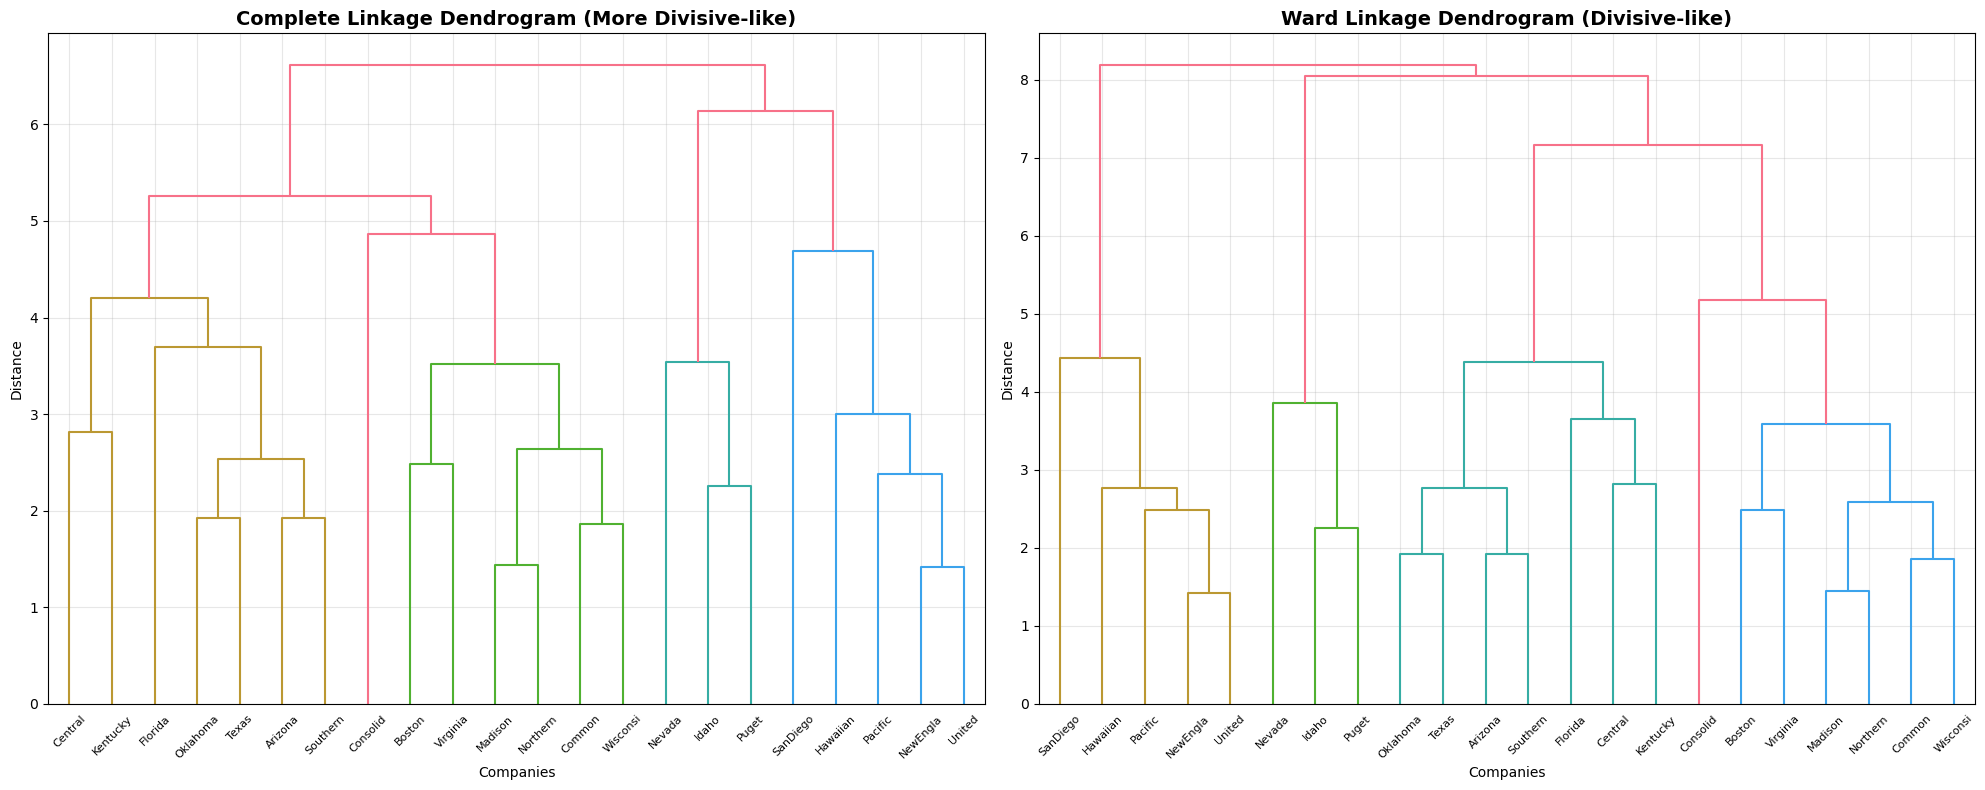

In [6]:
# Divisive Hierarchical Clustering (DIANA) - Alternative Implementation
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet

# Create divisive-like clustering using different linkage methods
print("Divisive Hierarchical Clustering Results:")
print("=" * 50)

# Use complete linkage (more divisive-like behavior)
linkage_complete = linkage(dat_z, method='complete', metric='euclidean')
linkage_ward = linkage(dat_z, method='ward')

print("Comparing different linkage methods:")
print(f"Complete linkage cophenetic correlation: {cophenet(linkage_complete, pdist(dat_z))[0]:.4f}")
print(f"Ward linkage cophenetic correlation: {cophenet(linkage_ward, pdist(dat_z))[0]:.4f}")
print(f"Average linkage cophenetic correlation: {cophenet(linkage_matrix, pdist(dat_z))[0]:.4f}")
print()

# Plot dendrograms for different linkage methods
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Complete linkage dendrogram
dendrogram(linkage_complete, 
           labels=dat_z.index,
           leaf_rotation=45,
           leaf_font_size=8,
           color_threshold=linkage_complete[-4, 2],
           ax=ax1)
ax1.set_title('Complete Linkage Dendrogram (More Divisive-like)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Companies')
ax1.set_ylabel('Distance')
ax1.grid(True, alpha=0.3)

# Ward linkage dendrogram
dendrogram(linkage_ward, 
           labels=dat_z.index,
           leaf_rotation=45,
           leaf_font_size=8,
           color_threshold=linkage_ward[-4, 2],
           ax=ax2)
ax2.set_title('Ward Linkage Dendrogram (Divisive-like)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Companies')
ax2.set_ylabel('Distance')
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Compare cluster assignments
clusters_complete = fcluster(linkage_complete, 5, criterion='maxclust')
clusters_ward = fcluster(linkage_ward, 5, criterion='maxclust')

print("Cluster comparison:")
print(f"Complete linkage creates {len(set(clusters_complete))} clusters")
print(f"Ward linkage creates {len(set(clusters_ward))} clusters")
print(f"Average linkage creates {len(set(fcluster(linkage_matrix, 5, criterion='maxclust')))} clusters")


### 4.6 PCA Plot with clusters

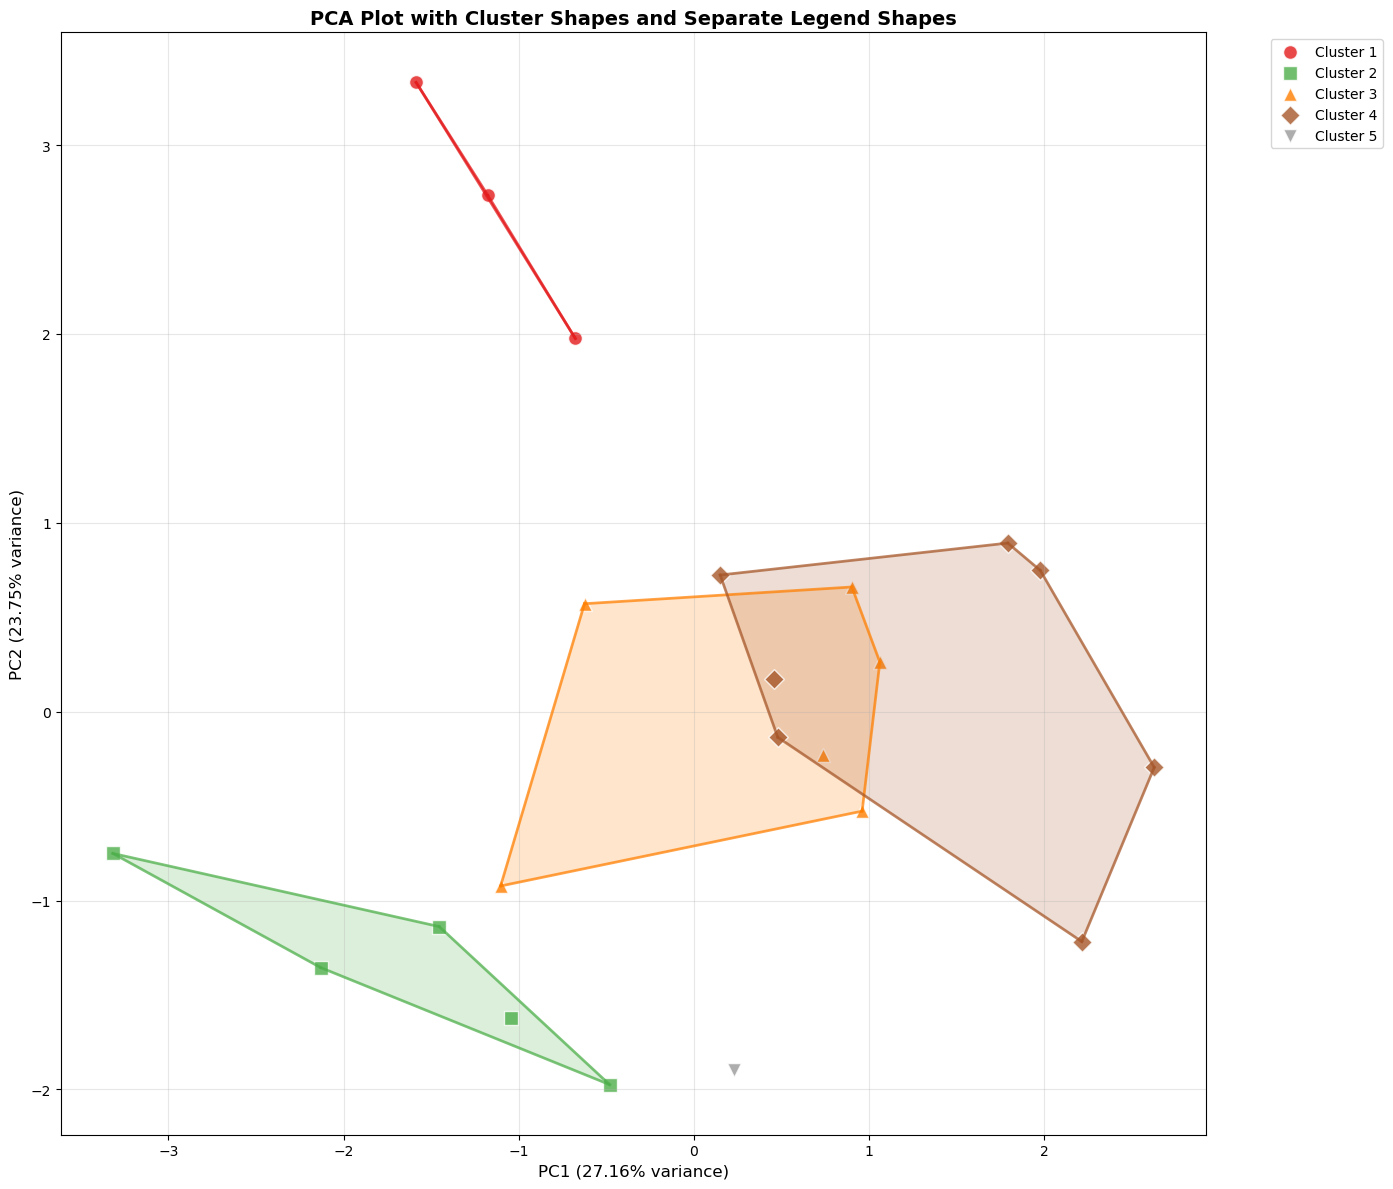

In [9]:
# PCA Plot with Cluster Shapes and Separate Legend Shapes
k = 5
clusters = fcluster(linkage_matrix, k, criterion='maxclust')

# PCA for visualization
pca = PCA(n_components=2)
dat_pca = pca.fit_transform(dat_z)

# Create scatter plot with cluster shapes and separate legend shapes
plt.figure(figsize=(14, 12))
colors = plt.cm.Set1(np.linspace(0, 1, k))

# Define different marker shapes for each cluster
markers = ['o', 's', '^', 'D', 'v']  # circle, square, triangle up, diamond, triangle down

for i in range(k):
    mask = clusters == (i + 1)
    cluster_points = dat_pca[mask]
    
    # Draw convex hull shape around cluster
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        # Fill the hull with soft color
        hull_points = cluster_points[hull.vertices]
        plt.fill(hull_points[:, 0], hull_points[:, 1], 
                color=colors[i], alpha=0.2)
        # Draw hull border
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 
                    color=colors[i], linewidth=2, alpha=0.7)
    
    # Plot points with different shapes
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], 
                c=[colors[i]], marker=markers[i], s=100, alpha=0.8, 
                edgecolors='white', linewidth=1, label=f'Cluster {i+1}')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)', fontsize=12)
plt.title('PCA Plot with Cluster Shapes and Separate Legend Shapes', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()


In [10]:
# Calculate cophenetic correlation
coph_cor, coph_dist = cophenet(linkage_matrix, dist_pu)
print(f"Cophenetic correlation: {coph_cor:.4f}")

# Calculate silhouette score
silhouette_avg = silhouette_score(dat_z, clusters)
print(f"Average silhouette score: {silhouette_avg:.4f}")

Cophenetic correlation: 0.7044
Average silhouette score: 0.2492


### 4.7 Optimal Number of Clusters

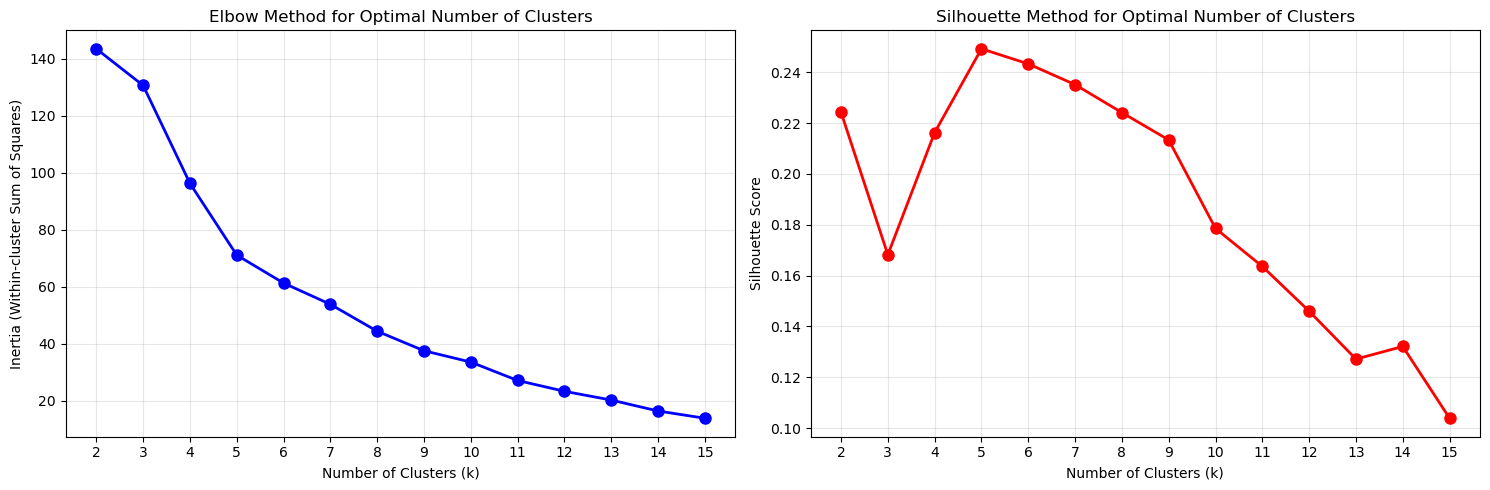

Results for k = 5 clusters:
- Inertia: 71.1079
- Silhouette Score: 0.2492
- Optimal k (Elbow): 4
- Optimal k (Silhouette): 5


In [11]:
# Optimal number of clusters analysis (fixed version without yellowbrick)
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Elbow Method - Calculate inertia for different numbers of clusters
k_range = range(2, 16)
inertias = []
silhouette_scores = []

for k in k_range:
    clustering = AgglomerativeClustering(n_clusters=k, linkage='average')
    cluster_labels = clustering.fit_predict(dat_z)
    
    # Calculate inertia (within-cluster sum of squares)
    inertia = 0
    for i in range(k):
        cluster_points = dat_z[cluster_labels == i]
        if len(cluster_points) > 0:
            centroid = cluster_points.mean()
            inertia += ((cluster_points - centroid) ** 2).sum().sum()
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette_score(dat_z, cluster_labels))

# Plot Elbow Method
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Within-cluster Sum of Squares)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal Number of Clusters')
plt.grid(True, alpha=0.3)
plt.xticks(k_range)

plt.tight_layout()
plt.show()

# Print results for k=5
k = 5
clustering = AgglomerativeClustering(n_clusters=k, linkage='average')
cluster_labels = clustering.fit_predict(dat_z)
inertia = inertias[k-2]  # k=5 is at index 3 (k_range starts at 2)
sil_score = silhouette_scores[k-2]

print(f"Results for k = {k} clusters:")
print(f"- Inertia: {inertia:.4f}")
print(f"- Silhouette Score: {sil_score:.4f}")
print(f"- Optimal k (Elbow): {k_range[np.argmin(np.diff(inertias)) + 1]}")
print(f"- Optimal k (Silhouette): {k_range[np.argmax(silhouette_scores)]}")


### 4.8 Variable Clustering

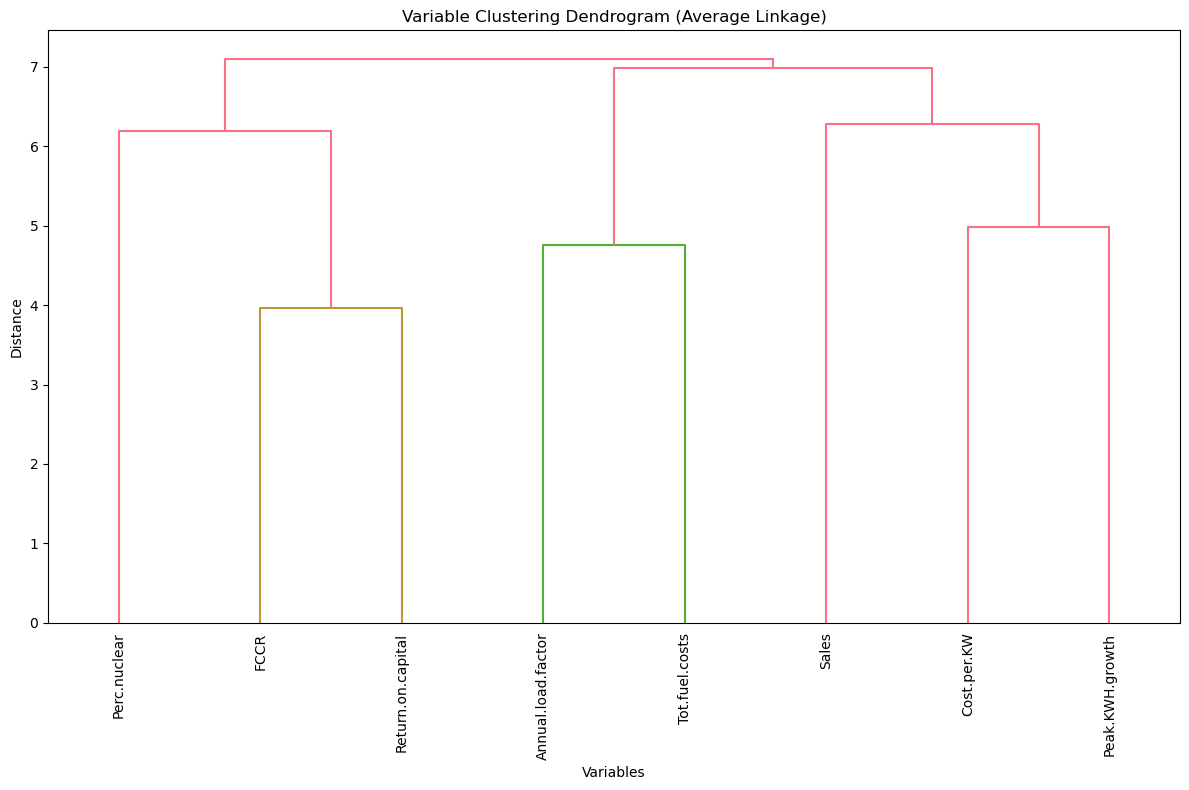

Variable clustering cophenetic correlation: 0.8667


In [12]:
# Transpose data for variable clustering
dat_z_trp = dat_z.T

# Create distance matrix for variables
dist_pu_trp = pdist(dat_z_trp, metric='euclidean')
dist_matrix_trp = squareform(dist_pu_trp)

# Perform clustering on variables
linkage_matrix_trp = linkage(dat_z_trp, method='average', metric='euclidean')

# Plot dendrogram for variables
plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix_trp, 
          labels=dat_z_trp.index,
          leaf_rotation=90,
          leaf_font_size=10)
plt.title('Variable Clustering Dendrogram (Average Linkage)')
plt.xlabel('Variables')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Calculate cophenetic correlation for variables
coph_cor_trp, _ = cophenet(linkage_matrix_trp, dist_pu_trp)
print(f"Variable clustering cophenetic correlation: {coph_cor_trp:.4f}")

### 4.9 Heatmap with Clustering

Now that we have performed AGNES on both the samples and the features, we can now combined the two results, together with a distance matrix heatmap, to better understand the relationship between the U.S. utility companies and their operations as it related to the measured features

<Figure size 1200x1000 with 0 Axes>

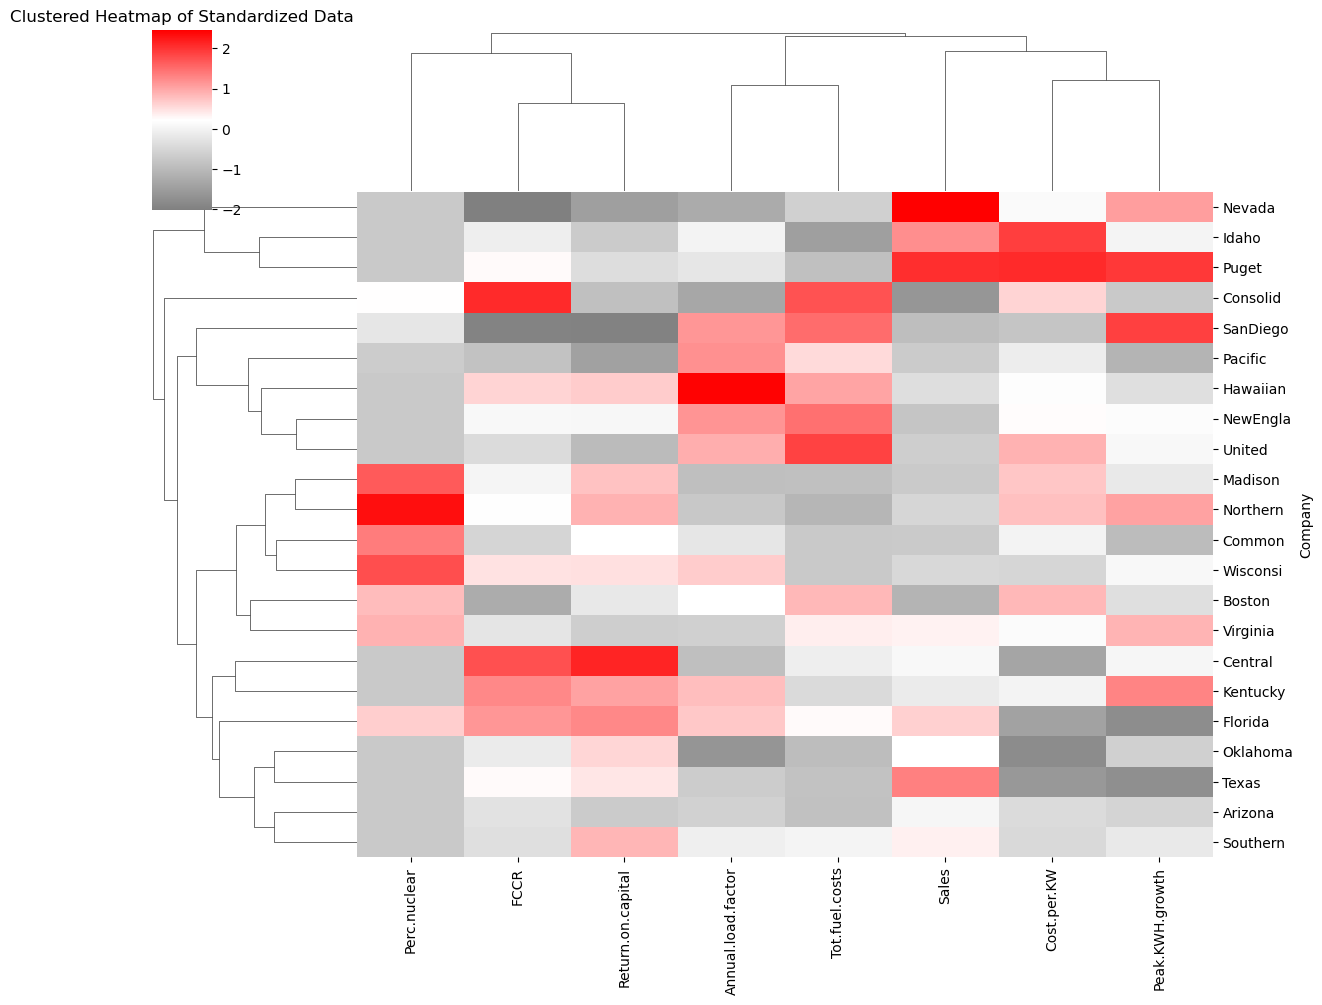

In [13]:
# Create heatmap with clustering
plt.figure(figsize=(12, 10))

# Create custom colormap
colors = ['gray', 'white', 'red']
n_bins = 15
cmap = sns.blend_palette(colors, n_colors=n_bins, as_cmap=True)

# Create heatmap
g = sns.clustermap(dat_z, 
                   cmap=cmap,
                   row_linkage=linkage_matrix,
                   col_linkage=linkage_matrix_trp,
                   xticklabels=True,
                   yticklabels=True,
                   figsize=(12, 10))

plt.title('Clustered Heatmap of Standardized Data')
plt.show()

### 4.10 Spider Dataset Analysis

In [14]:
url = "https://raw.githubusercontent.com/asim-cv/MAT6206/refs/heads/main/Datasets/Spider.csv"
spider_df = pd.read_csv(url)

display(spider_df.head())

,Alopacce,Alopcune,Alopfabr,Arctlute,Arctperi,Auloalbi,Pardlugu,Pardmont,Pardnigr,Pardpull,Trocterr,Zoraspin
0,25,10,0,0,0,4,0,60,12,45,57,4
1,0,2,0,0,0,30,1,1,15,37,65,9
2,15,20,2,2,0,9,1,29,18,45,66,1
3,2,6,0,1,0,24,1,7,29,94,86,25
4,1,20,0,2,0,9,1,2,135,76,91,17


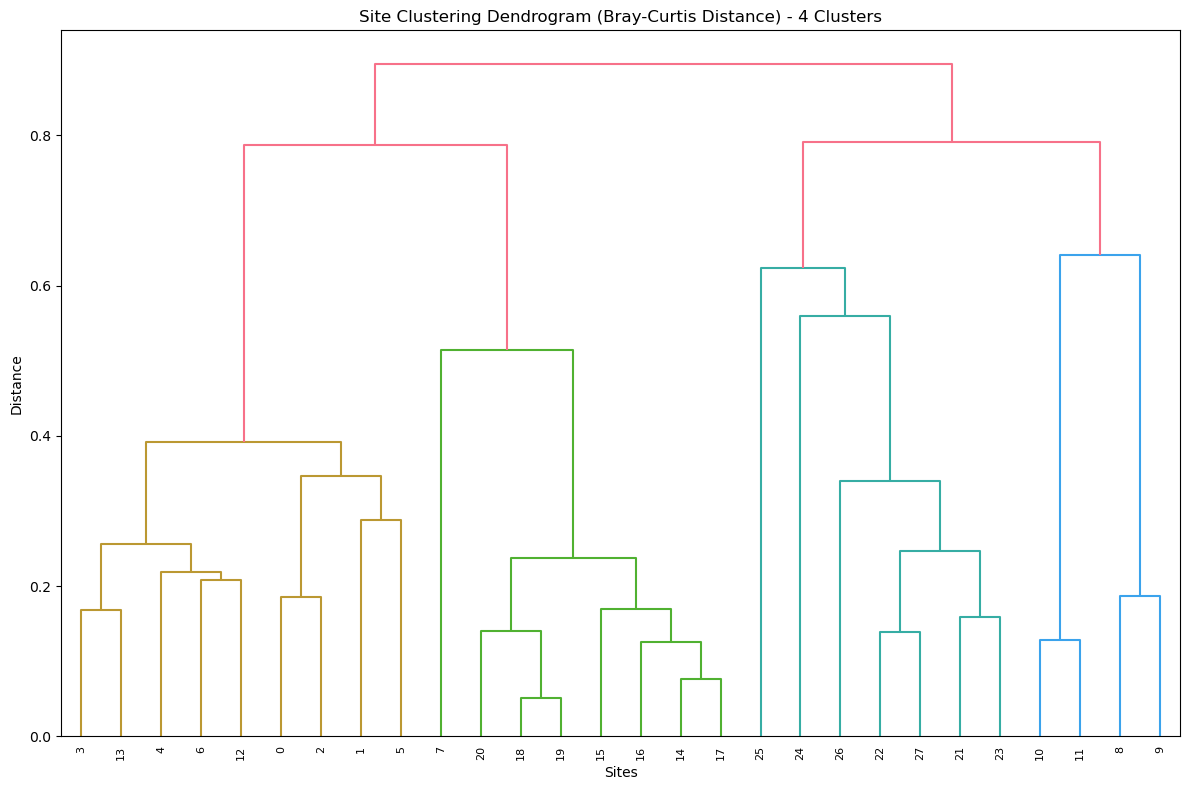

Site clustering cophenetic correlation: 0.9299

Cluster assignments for 4 clusters:
Cluster 1: [0, 1, 2, 3, 4, 5, 6, 12, 13]
Cluster 2: [7, 14, 15, 16, 17, 18, 19, 20]
Cluster 3: [21, 22, 23, 24, 25, 26, 27]
Cluster 4: [8, 9, 10, 11]


In [15]:
# Clustering of sites using Bray-Curtis distance - Modified to show 4 clusters
from scipy.spatial.distance import braycurtis

dist_site = pdist(spider_df, metric=braycurtis)
linkage_site = linkage(spider_df, method='average', metric=braycurtis)

# Plot dendrogram for sites showing 4 clusters
plt.figure(figsize=(12, 8))
dendrogram(linkage_site, 
          labels=spider_df.index,
          leaf_rotation=90,
          leaf_font_size=8,
          color_threshold=linkage_site[-3, 2])  # Set threshold to show 4 clusters
plt.title('Site Clustering Dendrogram (Bray-Curtis Distance) - 4 Clusters')
plt.xlabel('Sites')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Calculate cophenetic correlation for sites
coph_cor_site, _ = cophenet(linkage_site, dist_site)
print(f"Site clustering cophenetic correlation: {coph_cor_site:.4f}")

# Show cluster assignments for 4 clusters
clusters_site = fcluster(linkage_site, 4, criterion='maxclust')
print(f"\nCluster assignments for 4 clusters:")
for i in range(4):
    cluster_sites = spider_df.index[clusters_site == (i + 1)]
    print(f"Cluster {i+1}: {list(cluster_sites)}")


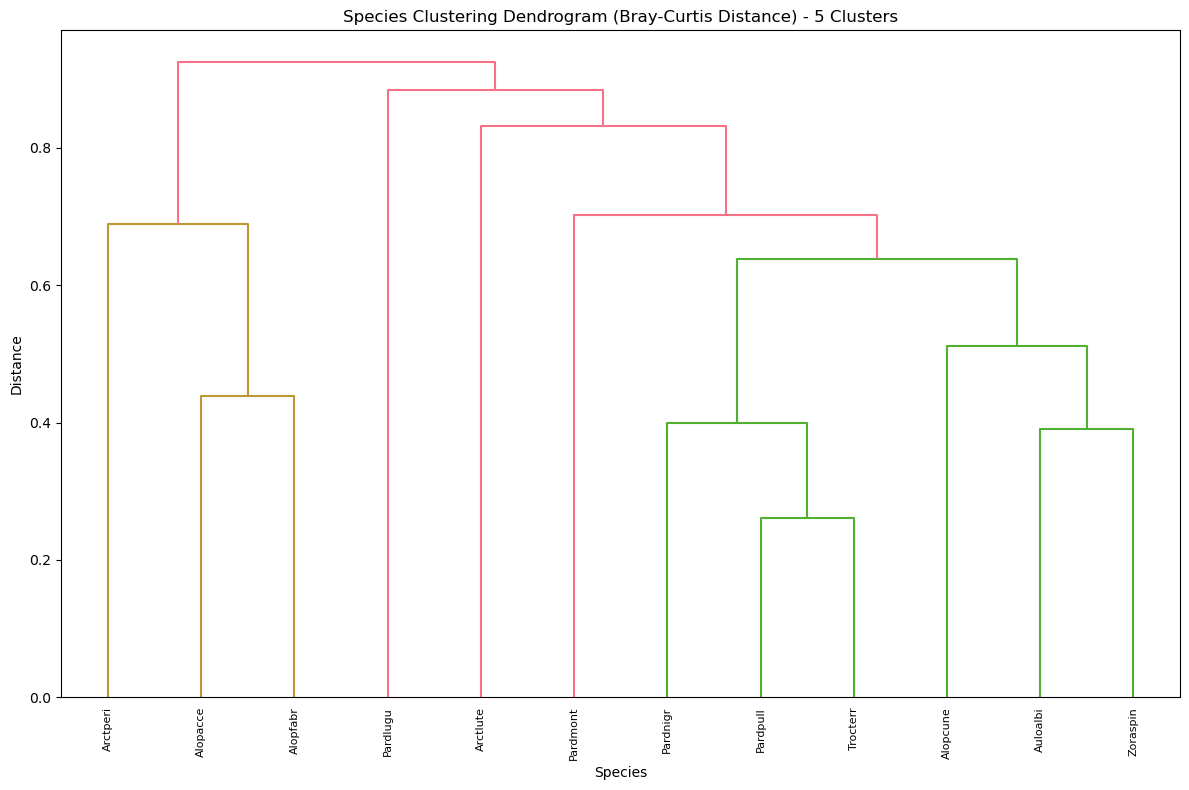

Species clustering cophenetic correlation: 0.9098


In [16]:
# Clustering of species
dist_species = pdist(spider_df.T, metric=braycurtis)
linkage_species = linkage(spider_df.T, method='average', metric=braycurtis)

# Plot dendrogram for species
plt.figure(figsize=(12, 8))
dendrogram(linkage_species, 
          labels=spider_df.columns,
          leaf_rotation=90,
          leaf_font_size=8,
          color_threshold=linkage_species[-4, 2])
plt.title('Species Clustering Dendrogram (Bray-Curtis Distance) - 5 Clusters')
plt.xlabel('Species')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

# Calculate cophenetic correlation for species
coph_cor_species, _ = cophenet(linkage_species, dist_species)
print(f"Species clustering cophenetic correlation: {coph_cor_species:.4f}")

<Figure size 1200x1000 with 0 Axes>

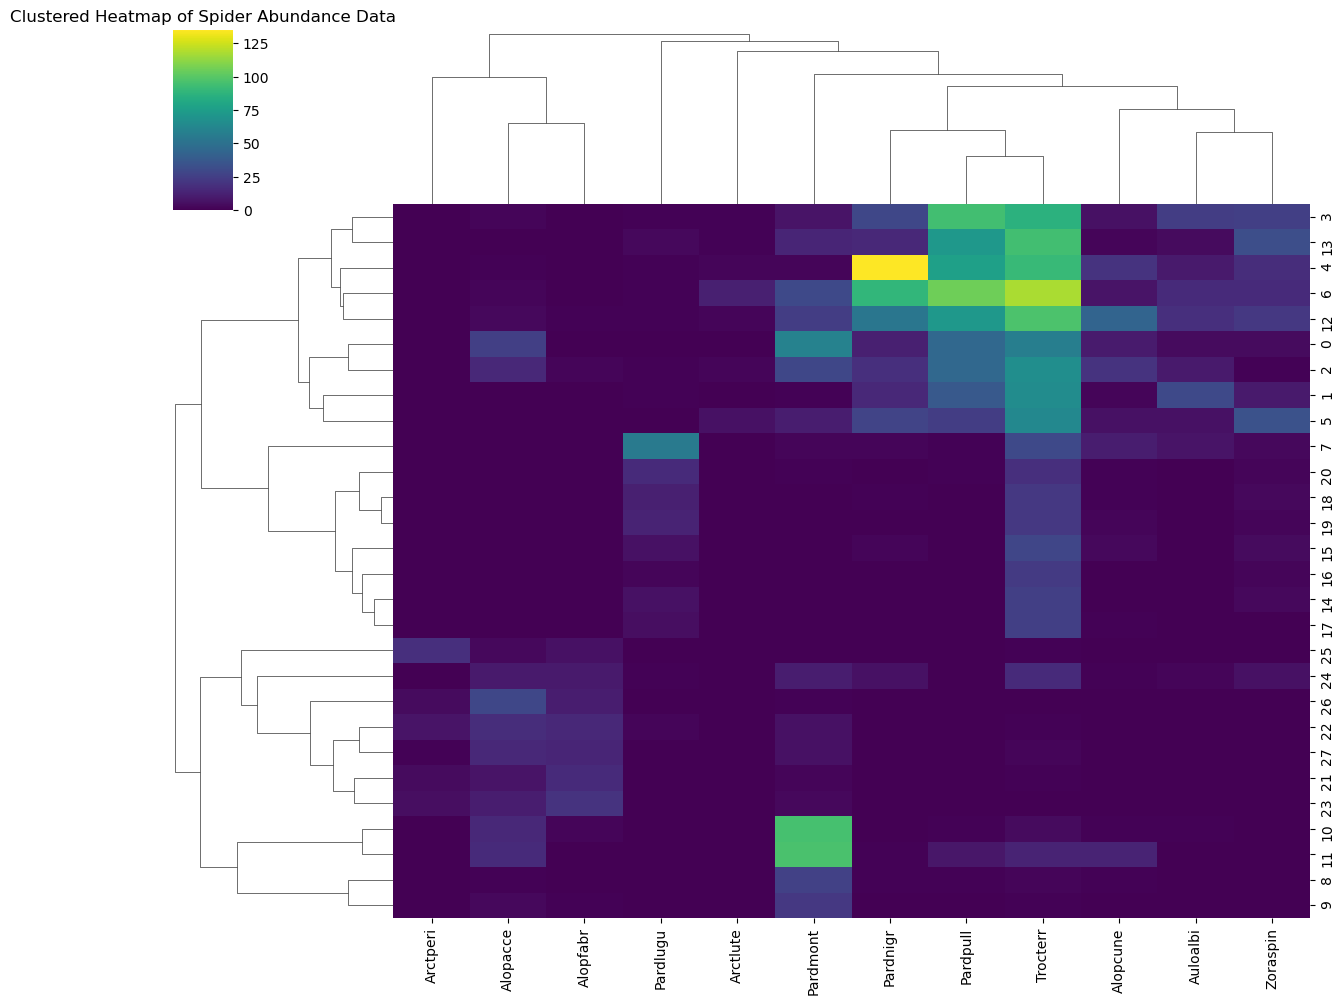

In [17]:
# Create heatmap for spider data
plt.figure(figsize=(12, 10))

g = sns.clustermap(spider_df, 
                   cmap='viridis',
                   row_linkage=linkage_site,
                   col_linkage=linkage_species,
                   xticklabels=True,
                   yticklabels=True,
                   figsize=(12, 10))

plt.title('Clustered Heatmap of Spider Abundance Data')
plt.show()

Besides the obvious with Pardnigr, Pardpull, Trocterr and Pardmont and the corresponding sites, it is difficult to make any sensible observation with the other species/sites. This is largely due to the fact the few large counts (as seen by the red cells in the above plot) that are >80 are drowning out the smaller counts (around 10 or less), and the latter make up the majority of the cases (see legend key). A way to overcome this is by transforming the whole dataset using, say the fourth-root transformation. A transformation reducing the distances between the low and high counts, and as a result, the lower values are given more emphasis. In biology, rare species are often times just as important as the common species.

<Figure size 1200x1000 with 0 Axes>

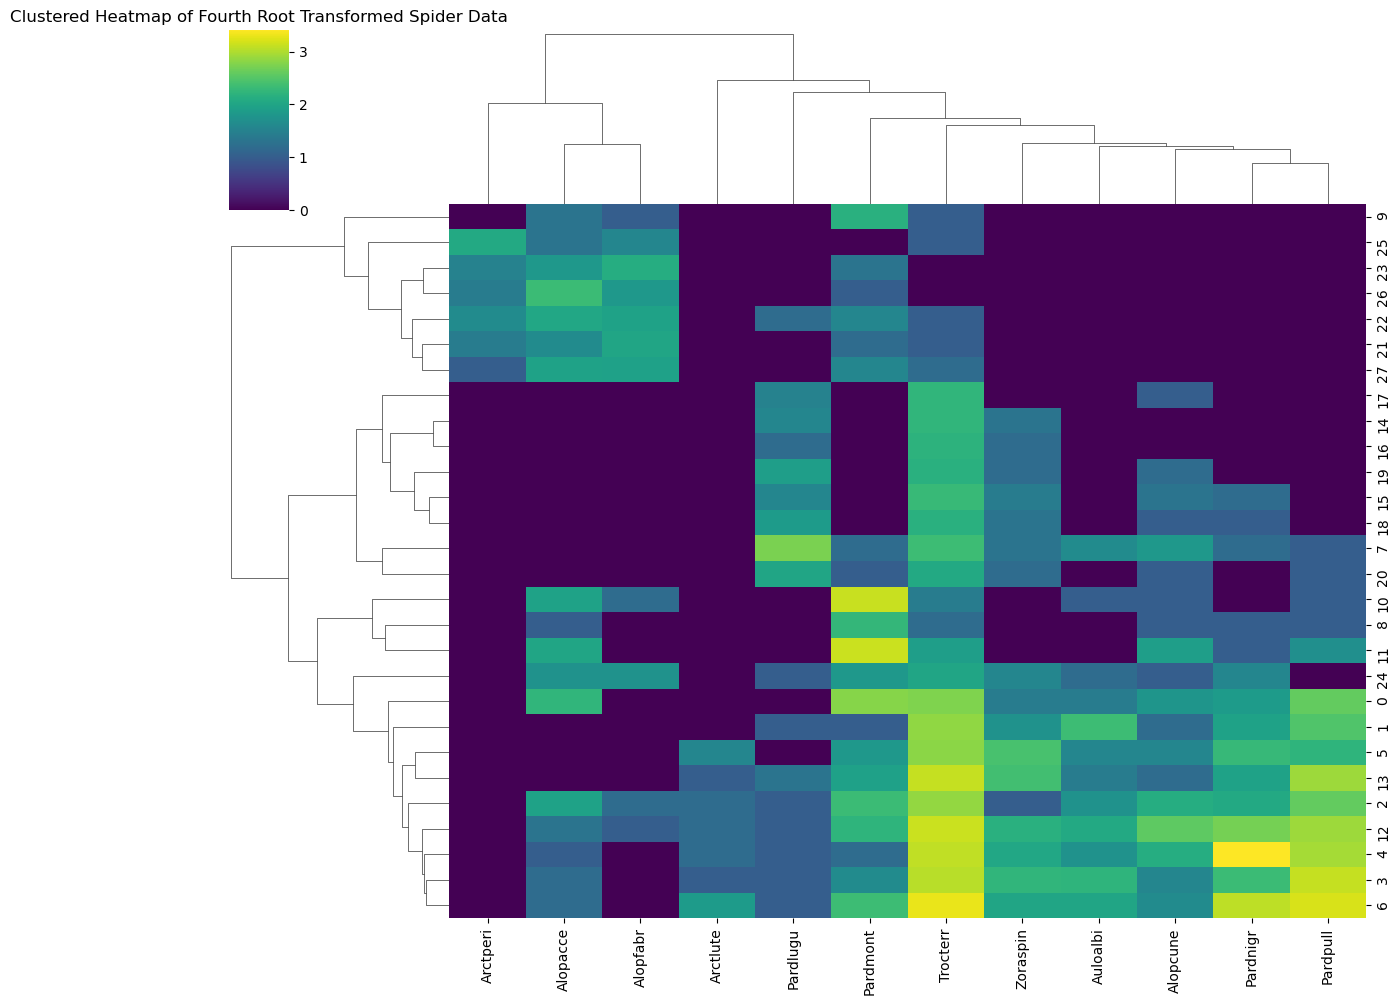

In [18]:
# Fourth root transformation
dat_abund_4root = spider_df ** (1/4)

# AGNES by sites on transformed data
dist_site_4root = pdist(dat_abund_4root, metric=braycurtis)
linkage_site_4root = linkage(dat_abund_4root, method='average', metric=braycurtis)

# AGNES by species on transformed data
dist_species_4root = pdist(dat_abund_4root.T, metric=braycurtis)
linkage_species_4root = linkage(dat_abund_4root.T, method='average', metric=braycurtis)

# Create heatmap for transformed data
plt.figure(figsize=(12, 10))

g = sns.clustermap(dat_abund_4root, 
                   cmap='viridis',
                   row_linkage=linkage_site_4root,
                   col_linkage=linkage_species_4root,
                   xticklabels=True,
                   yticklabels=True,
                   figsize=(12, 10))

plt.title('Clustered Heatmap of Fourth Root Transformed Spider Data')
plt.show()